In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google_trans_new import google_translator

translator = google_translator() 

# Data Analysis & Cleaning

First, it is necessary to look into the dataset and compute some statistics to get an overview of its main characteristics.

In [2]:
df = pd.read_csv('dataset_sa.csv', encoding='ansi')
df

,topic,doc_id,label,doc_pred,-,bert_sentiment,lexicon_sentiment,topical,topic_similarity,tokens,entities,Column1,text,sent_id
0,Donald Trump,24,0,0.660882,NaN,0.237890,1.023380,0,0,11,1,57,Vinder Real Madrid Champions League for fjerde...,72
1,Donald Trump,24,0,0.660882,NaN,-0.193494,0.977107,0,0,7,1,50,Vinder Caroline Wozniacki en Grand Slam-turner...,16
2,Donald Trump,24,0,0.660882,NaN,-1.182156,-0.061737,1,0,12,2,81,Vil Demokraterne i Repræsentanternes Hus indle...,48
3,Joe Biden,1,0,-1.149904,NaN,0.825722,0.440000,0,0,13,2,62,"Vi vil vinde,"" skriver han på Twitter efter Pe...",13
4,Donald Trump,26,-1,-1.426556,NaN,0.193577,-0.111888,1,0,15,1,67,Vi er nødt til rent faktisk at gøre en forskel...,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,Boris Johnson,4,-1,-1.055707,NaN,-0.919533,-0.085106,0,0,15,0,64,"""Det er ikke noget, jeg nogensinde vil kunne f...",5
201,Donald Trump,28,2,-0.873057,NaN,0.640317,0.216216,0,0,11,0,52,""" MADS FUGLEDE, VÆRT FOR PODCASTEN ""KAMPAGNESP...",22
202,Donald Trump,38,-2,-1.374837,NaN,-0.803127,-0.125000,0,0,10,1,58,""" Indalik Høegh har svært ved at seGrønlandsom...",17
203,Donald Trump,6,2,-0.724118,NaN,-0.282931,0.036364,0,0,18,0,68,"- Det har taget mange årtier at nå hertil, lad...",16


In [3]:
df.dtypes

topic                 object
doc_id                 int64
label                  int64
doc_pred             float64
-                    float64
bert_sentiment       float64
lexicon_sentiment    float64
topical                int64
topic_similarity       int64
tokens                 int64
entities               int64
Column1                int64
text                  object
sent_id                int64
dtype: object

In [4]:
(df == 0).all()

topic                False
doc_id               False
label                False
doc_pred             False
-                    False
bert_sentiment       False
lexicon_sentiment    False
topical              False
topic_similarity      True
tokens               False
entities             False
Column1              False
text                 False
sent_id              False
dtype: bool

In [5]:
(df.isnull()).all()

topic                False
doc_id               False
label                False
doc_pred             False
-                     True
bert_sentiment       False
lexicon_sentiment    False
topical              False
topic_similarity     False
tokens               False
entities             False
Column1              False
text                 False
sent_id              False
dtype: bool

The dataset is composed of 205 rows and 14 columns. Moreover, there are 2 columns with no information that we can remove: _-_ and _topic_similarity_.

In [6]:
del df['topic_similarity']
del df['-']

The goal is to predict the sentiment analysis score contained in _label_, which seems to be a discrete variable. In this situation we are talking about a classification problem with 5 different classes.

Let's see how _label_ values are distributed:

Text(0, 0.5, 'Label')

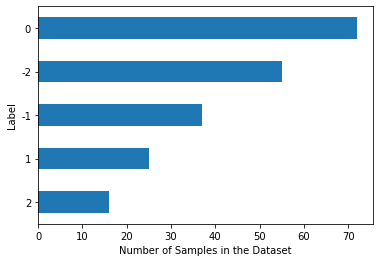

In [7]:
ax = df['label'].value_counts(sort=True, ascending=True).plot(kind='barh')
ax.set_xlabel('Number of Samples in the Dataset')
ax.set_ylabel('Label')

On one hand, we can see in the plot above that there are less than 20 tweets labeled with a 2. On the other hand, the dataset has more than 70 tweets labeled with a 0. None of the classes has aproximately the same number of samples, which means that this is an unbalanced dataset.

Other big problem is related with the size of the dataset. Even if we apply some transformations to the dataset and we balance the number of samples per class, there are very few samples to train and test a machine learning model for this classification task. The minority class (label '2') has only 16 samples before splitting the data into train and test sets.

Let's continue taking a look and know more about each feature before we try to deal with these two problems.

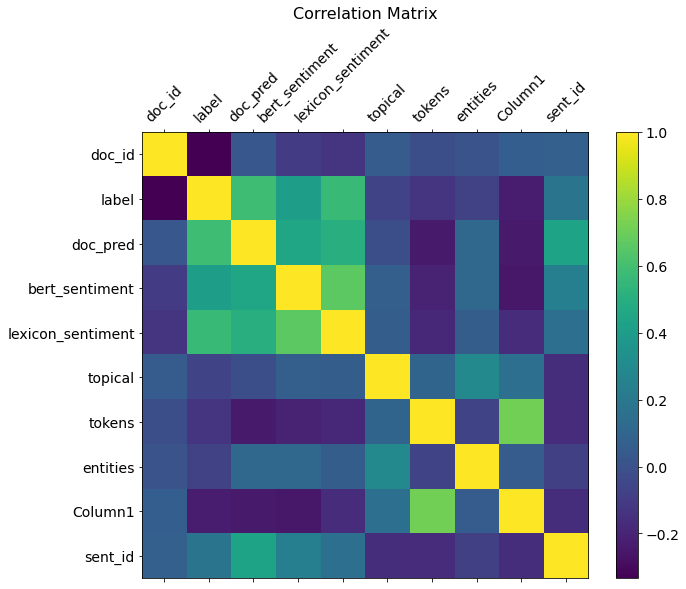

In [8]:
f = plt.figure(figsize=(10, 8))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

From the correlation matrix above we can say that there's some correlation between _doc_pred_, _bert_sentiment_, _lexicon_sentiment_ and _label_. All of them seem to be some kind of sentiment score of each tweet.

Both _doc_id_ and _sent_id_ seem to be identifiers without any correlation with the rest of the features. Since we don't have more information about them, (after have been checking a bit more) we can drop those columns from the dataset.

Furthermore, there's correlation between _tokens_ and _Column1_. It's easy to notice that _Column1_ refers to the number of characters per tweet as shown below:

In [9]:
for index, row in df.iterrows():
    if not row['Column1'] == len(row['text']):
        print("Column1 is not the length of the tweet.")

In order to get tokens from the Danish tweets in the future, we add a new column called _text_eng_ containing the English translation of the tweets.

In [10]:
df['text_eng'] = df.apply (lambda row: translator.translate(row['text'],lang_src='da', lang_tgt='en'), axis=1)

Taking a look to _entities_, we can check that this column is a counter that indicates the number of institutions/names mentioned in each tweet. Tweets containing 2 entities are printed below:

In [11]:
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.max_colwidth')

print_full(df.loc[df['entities'] == 2]['text_eng'])

2                           Will the Democrats in the House of Representatives initiate a federal lawsuit against Donald Trump? 
3                                                             We want to win, "he wrote on Twitter after Pelosi's announcement. 
5      The President of the United States, Donald Trump, has clearly broken the law and must be brought before a federal court. 
8                                    Ukraine earlier Thursday invited Britain to take part in the investigation into the crash. 
9                                                                 Does the Swedish Academy award the Nobel Prize in Literature? 
19                                       The Complacent Class "Tyler Cowen St. Martin's Press 256 pages $ 15.65 on Amazon.com 5 
22                                                                     Sweden is mentioned as an option along with Switzerland. 
30                                  So much I have then learned from The Art of the Deal (partly 

The categorical feature _topical_ indicates when the topic of the tweet is explicitly mentioned in the body of the tweet. There are only 3 topics: Donald Trump, Boris Johnson and Joe Biden. Some of the tweets matching this condition are printed below:

In [12]:
print_full(df.loc[df['topical'] == 1]['text_eng'])

2                       Will the Democrats in the House of Representatives initiate a federal lawsuit against Donald Trump? 
4                                                                 We have to actually make a difference, Donald Trump said. 
12     On the contrary, it was precisely the leisurely middle class that elected Donald Trump in the 2016 primary election. 
17                                    On Tuesday last week, Donald took the Trump phone and called Boris Johnson in London. 
30                              So much I have then learned from The Art of the Deal (partly written by Donald Trump, ed.). 
34                           However, Prime Minister Boris Johnson and Brexit party Nigel Farage had chosen not to show up. 
37                                                                        President, Donald Trump is not going to be there. 
42                              Also in the first round of voting last week, Boris Johnson received clearly the most votes. 


The plot below shows the mean of each of the three sentiment scores according to the final label, giving a visual idea of how they are correlated:

<ipython-input-13-227bef8dfdfe>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_label = df.groupby(['label'])['doc_pred','bert_sentiment','lexicon_sentiment'].mean()


<AxesSubplot:xlabel='label'>

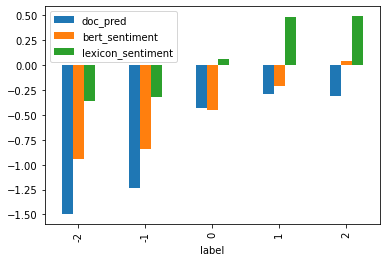

In [13]:
df_label = df.groupby(['label'])['doc_pred','bert_sentiment','lexicon_sentiment'].mean()
df_label.plot.bar()

To finish this section, a cleaner version of the dataset is saved below.

In [14]:
del df['doc_id']
del df['sent_id']
df.columns.values[8] = 'length'
df

,topic,label,doc_pred,bert_sentiment,lexicon_sentiment,topical,tokens,entities,length,text,text_eng
0,Donald Trump,0,0.660882,0.237890,1.023380,0,11,1,57,Vinder Real Madrid Champions League for fjerde...,Will Real Madrid win the Champions League for ...
1,Donald Trump,0,0.660882,-0.193494,0.977107,0,7,1,50,Vinder Caroline Wozniacki en Grand Slam-turner...,Will Caroline Wozniacki win a Grand Slam tourn...
2,Donald Trump,0,0.660882,-1.182156,-0.061737,1,12,2,81,Vil Demokraterne i Repræsentanternes Hus indle...,Will the Democrats in the House of Representat...
3,Joe Biden,0,-1.149904,0.825722,0.440000,0,13,2,62,"Vi vil vinde,"" skriver han på Twitter efter Pe...","We want to win, ""he wrote on Twitter after Pel..."
4,Donald Trump,-1,-1.426556,0.193577,-0.111888,1,15,1,67,Vi er nødt til rent faktisk at gøre en forskel...,"We have to actually make a difference, Donald ..."
...,...,...,...,...,...,...,...,...,...,...,...
200,Boris Johnson,-1,-1.055707,-0.919533,-0.085106,0,15,0,64,"""Det er ikke noget, jeg nogensinde vil kunne f...","""It's not something I'll ever be able to commi..."
201,Donald Trump,2,-0.873057,0.640317,0.216216,0,11,0,52,""" MADS FUGLEDE, VÆRT FOR PODCASTEN ""KAMPAGNESP...","""MADS BIRDS, HOSTED THE PODCAST"" CAMPAIGN TRAC..."
202,Donald Trump,-2,-1.374837,-0.803127,-0.125000,0,10,1,58,""" Indalik Høegh har svært ved at seGrønlandsom...","""Indalik Høegh has a hard time seeing Greenlan..."
203,Donald Trump,2,-0.724118,-0.282931,0.036364,0,18,0,68,"- Det har taget mange årtier at nå hertil, lad...","- It has taken many decades to get here, let's..."


In [15]:
df.to_csv(r'dataset_clean.csv', index = False, encoding='ansi')

# Data Processing

In this section we are going to try to minimize the impact of the unbalanced dataset on the different ML models.

We can consider two ways of solving this problem: oversampling or undersampling. Since we have 5 different classes with very different number of samples per class, the approach we are going to follow will be a mix of both.

Let's remember how the samples are distributed in the dataset depending on its _label_ value:

Text(0, 0.5, 'Label')

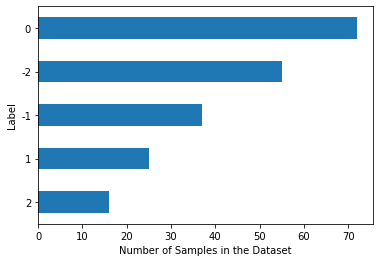

In [16]:
ax = df['label'].value_counts(sort=True, ascending=True).plot(kind='barh')
ax.set_xlabel('Number of Samples in the Dataset')
ax.set_ylabel('Label')

First, we are going to undersample '0' and '-2' groups to have 37 samples each, which is the number of samples the class '-1' has. The process will pick random samples within these 2 groups and remove them from the dataset.

Text(0, 0.5, 'Label')

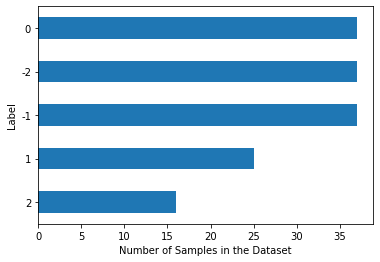

In [17]:
import imblearn

# define undersample strategy
classes = {0: 37, -2: 37}
undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=classes)

# create X and y
X = df.loc[:, df.columns != 'label']
y = df['label']

# fit and apply the transform
X_over, y_over = undersample.fit_resample(X, y)

ax = y_over.value_counts(sort=True, ascending=True).plot(kind='barh')
ax.set_xlabel('Number of Samples in the Dataset')
ax.set_ylabel('Label')

We can see now that classes '0', '-1' and '-2' have a similar number of samples.

Second, we are going to oversample '1' and '2' groups to have 37 samples each, like the rest of the classes. The process will duplicate random samples within these 2 groups and add them to the dataset.

Text(0, 0.5, 'Label')

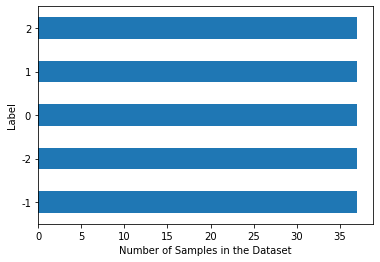

In [18]:
# define oversample strategy
classes = {1: 37, 2: 37}
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy=classes)

# update X and y
X = X_over
y = y_over

# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)

# update X and y
X = X_over
y = y_over

ax = y_over.value_counts(sort=True, ascending=True).plot(kind='barh')
ax.set_xlabel('Number of Samples in the Dataset')
ax.set_ylabel('Label')

Now all the classes have 37 samples each, resulting in a balanced dataset.

On one hand, this process has consequences. As classes '1' and '2' have duplicate samples, some overfitting could appear in the ML model when trying to predict these two classes. Moreover, now it will be more difficult for the model to predict classes '0' and '-2' since it has less samples to learn from them while is being trained.

On the other hand, if we do not balance the dataset we will find what we call the "Accuracy Paradox" when evaluating the ML model. The algorithms will want to assign most of their observations to the majority classes, resulting on a high accuracy value. Testing the model on a balanced dataset will show us that, actually, it is not generalizing well.

In [19]:
# concatenate X and y into a new balanced dataframe
df = pd.concat([X, y], axis=1)

df.to_csv(r'dataset_balanced.csv', index = False, encoding='ansi')

In [20]:
df

,topic,doc_pred,bert_sentiment,lexicon_sentiment,topical,tokens,entities,length,text,text_eng,label
0,Donald Trump,-1.558372,-1.195102,-0.470588,0,13,0,72,Imens bliver passagererne mere og mere urolige...,"Meanwhile, the passengers become more and more...",-2
1,Boris Johnson,-1.698865,-0.751376,-0.247788,1,11,2,72,Channel 4s isskulpturer gjorde Boris Johnsons ...,Channel 4's ice sculptures made Boris Johnson'...,-2
2,Donald Trump,-1.428882,0.119638,-0.953488,0,7,0,55,Han er udpeget afjustitsministerietsom særlig ...,He has been appointed by the Ministry of Justi...,-2
3,Donald Trump,-1.457036,-0.526979,-0.007380,0,18,0,86,"Og muligvis er de nuværende regler om, hvad ma...",And possibly the current rules about what one ...,-2
4,Donald Trump,-1.722569,-0.700014,-0.142857,0,13,1,62,"Hvis der kommer en rigsretssag mod Trump, vent...","If there is a federal lawsuit against Trump, i...",-2
...,...,...,...,...,...,...,...,...,...,...,...
180,Boris Johnson,0.529619,1.057251,0.394904,1,14,1,86,Også i første afstemningsrunde i forrige uge m...,"Also in the first round of voting last week, B...",2
181,Donald Trump,-0.724118,0.499768,0.869565,0,13,2,61,"- De behandler os med stor respekt, sagde Trum...","""They treat us with great respect,"" Trump said...",2
182,Boris Johnson,0.529619,0.314489,0.137931,0,18,1,88,"Denne gang er det 46-årige Rory Stewart, der v...","This time it’s 46-year-old Rory Stewart, who w...",2
183,Donald Trump,-0.724118,-0.161167,0.038462,0,17,0,66,"Det har taget mange årtier at nå hertil, lad o...","It has taken many decades to get here, let's s...",2


# Sentiment Analysis

Since the dataset is small and it has not a lot of features, could be interesting to add more sentiment analysis scores and see if it helps to improve the performance of the models. Two Python libraries has been considered: TextBlob and VADER.

In addition to that, at the end of this section we will check the precision and recall for the BERT sentiment score already computed in the dataset (_bert_sentiment_ column).

### TextBlob

In [21]:
from sklearn.metrics import precision_score, recall_score
from textblob import TextBlob

<ipython-input-22-3bff0d69308f>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_textblob = df.groupby(['label'])['y_textblob_polarity','y_textblob_subjectivity'].mean()


<AxesSubplot:xlabel='label'>

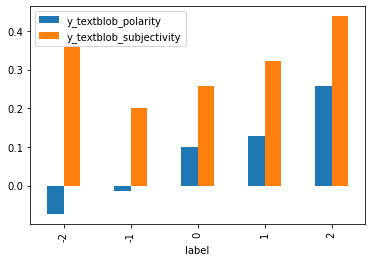

In [22]:
# we save TextBlob polarity and subjetivity scores in 2 different columns
df['y_textblob_polarity'] = df.apply (lambda row: TextBlob(row['text_eng']).sentiment.polarity, axis=1)
df['y_textblob_subjectivity'] = df.apply (lambda row: TextBlob(row['text_eng']).sentiment.subjectivity, axis=1)

df_textblob = df.groupby(['label'])['y_textblob_polarity','y_textblob_subjectivity'].mean()
df_textblob.plot.bar()

As we can see in the plot above, the TextBlob's subjetivity score won't be relevant for us since its mean is not correlated with _label_. Despite of this, the polarity score could be interesting so we keep the column and multiply its values to have values between -2 and 2.

In [23]:
del df['y_textblob_subjectivity']
df.columns.values[11] = 'y_textblob'
df['y_textblob'] = df['y_textblob'].apply(lambda x: x*2)

In [24]:
pc = precision_score(df['label'], df['y_textblob'].astype(int), average=None)
rc = recall_score(df['label'], df['y_textblob'].astype(int), average=None)
print("Precision: %.2f"% np.mean(pc))
print("Recall: %.2f"% np.mean(rc))

Precision: 0.30
Recall: 0.20


Its precision and recall by themselfs are not relevant, but we keep the values to see if they are useful in the future.

### VADER

In [25]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\carlo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<AxesSubplot:xlabel='label'>

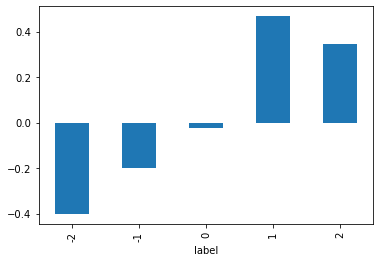

In [26]:
# compute VADER sentiment score and scale it to [-2, 2]
df['y_vader'] = df.apply (lambda row: vader.polarity_scores(row['text_eng'])['compound'], axis=1)
df['y_vader'] = df['y_vader'].apply(lambda x: x*2)

df_vader = df.groupby(['label'])['y_vader'].mean()
df_vader.plot.bar()

In [27]:
pc = precision_score(df['label'], df['y_vader'].astype(int), average=None)
rc = recall_score(df['label'], df['y_vader'].astype(int), average=None)
print("Precision: %.2f"% np.mean(pc))
print("Recall: %.2f"% np.mean(rc))

Precision: 0.16
Recall: 0.21


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Similar results, its precision and recall by themselfs are not relevant but we keep the values to see if they are useful in the future.

### BERT

In [28]:
pc = precision_score(df['label'], df['bert_sentiment'].astype(int), average=None)
rc = recall_score(df['label'], df['bert_sentiment'].astype(int), average=None)
print("Precision: %.2f"% np.mean(pc))
print("Recall: %.2f"% np.mean(rc))

Precision: 0.16
Recall: 0.22


Once more, similar results. This is enough to show that we need a proper classifier using the rest of the data to improve the performance.

In [29]:
df.to_csv(r'dataset_expanded.csv', index = False, encoding='ansi')

# ML Classification Models

### Looking for ML model candidates with PyCaret

PyCaret library is usually my choice to check which ML models could perform better for a concrete dataset and task. It provides a quick comparison between most used models and allows hyperparameter tuning among other functionalities.

To simplify the content of this notebook, the code implemented with PyCaret can be found in two different notebooks (using a different environment for PyCaret to avoid problems with dependencies and versions):
- _PyCaret_Infomedia_: contains the experiments done with the final feature configuration.
- _PyCaret_Infomedia_Setup_Analysis_: contains varius classifier comparisons with different feature setups.

The figure below shows a promising performance from Gradient Boosting Classifier with the validation set compared to other models:

![title](img/model_comparison.png)

This performance seems to be also generalizing well with the test set, although with a small dataset everytime you run the code the results change a bit (approx. +/-0.05):

![title](img/gbc_test.png)

These results are achieved with the parameters showed below (PyCaret is using sklearn library internally):

In [30]:
'''
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=7149, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
'''

"\nGradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,\n                           learning_rate=0.1, loss='deviance', max_depth=3,\n                           max_features=None, max_leaf_nodes=None,\n                           min_impurity_decrease=0.0, min_impurity_split=None,\n                           min_samples_leaf=1, min_samples_split=2,\n                           min_weight_fraction_leaf=0.0, n_estimators=100,\n                           n_iter_no_change=None, presort='deprecated',\n                           random_state=7149, subsample=1.0, tol=0.0001,\n                           validation_fraction=0.1, verbose=0,\n                           warm_start=False)\n"

These results have been achieved with the feature configuration showed below after trying with many different setups (take a look to the notebook _PyCaret_Infomedia_Setup_Analysis_ for more details). Notice that _bert_sentiment_ has been excluded, _topic_ and _topical_ are categorical and none of the extra features (_y\_textblob_ and _y\_vader_) have been included finally.

![title](img/feature_config.png)

We can see in the Precision-Recall plot below that the performance seems to be very promising despite of the size of the dataset:

![title](img/gbc_plot.png)

## Gradient Boosting Classifier with Scikit-learn

Now it's time to check if Gradient Boosting Classifier is performing that well and if we can tune its hyperparameters a bit more. We are going to use directly Scikit-learn for this task.

In [31]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle

In [32]:
# new dataframe containing only the features we are going to use (not excluding 'bert_sentiment' yet)
data = [df['bert_sentiment'],df['topic'],df['doc_pred'],df['lexicon_sentiment'],
        df['topical'],df['tokens'],df['entities'],df['label']]
headers = ['bert_sentiment','topic','doc_pred','lexicon_sentiment','topical','tokens','entities','label']
df_op = pd.concat(data, axis=1, keys=headers).sort_index()

# transform feature 'topic' to categorical ('topical' is already categorical)
df_op = pd.get_dummies(df_op, columns=['topic'])
df_op

,bert_sentiment,doc_pred,lexicon_sentiment,topical,tokens,entities,label,topic_Boris Johnson,topic_Donald Trump,topic_Joe Biden
0,-1.195102,-1.558372,-0.470588,0,13,0,-2,0,1,0
1,-0.751376,-1.698865,-0.247788,1,11,2,-2,1,0,0
2,0.119638,-1.428882,-0.953488,0,7,0,-2,0,1,0
3,-0.526979,-1.457036,-0.007380,0,18,0,-2,0,1,0
4,-0.700014,-1.722569,-0.142857,0,13,1,-2,0,1,0
...,...,...,...,...,...,...,...,...,...,...
180,1.057251,0.529619,0.394904,1,14,1,2,1,0,0
181,0.499768,-0.724118,0.869565,0,13,2,2,0,1,0
182,0.314489,0.529619,0.137931,0,18,1,2,1,0,0
183,-0.161167,-0.724118,0.038462,0,17,0,2,0,1,0


In [33]:
# shuffle dataset rows and create training (75%) & test (25%) sets
df_op = shuffle(df_op)
X_train, X_test, y_train, y_test = train_test_split(df_op.loc[:, df_op.columns != 'label'],
                                                    df_op['label'], test_size=0.25, random_state=123)

# save 'bert_sentiment' values from test set
y_test_bert = X_test['bert_sentiment']

# remove 'bert_sentiment' from both sets
del X_train['bert_sentiment']
del X_test['bert_sentiment']

# normalize data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# split train set into train (75%) and validation (25%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=246)

In [34]:
# try with different learning rates and main parameters from PyCaret
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, 
                                        max_features=None, max_depth=3, tol=0.0001,
                                        min_samples_leaf=1, min_samples_split=2, random_state=1234)
    gb_clf.fit(X_train, y_train)

    print("\nLearning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_val, y_val)))


Learning rate:  0.05
Accuracy score (training): 1.000
Accuracy score (validation): 0.829

Learning rate:  0.075
Accuracy score (training): 1.000
Accuracy score (validation): 0.857

Learning rate:  0.1
Accuracy score (training): 1.000
Accuracy score (validation): 0.857

Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.857

Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.857

Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.914

Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.857


Seems that the model is performing well as expected, but taking a look to the accuracies with the validation set we can not have a clear preference for a learning rate.

In order to identify the best parameters for the model we are going to perform random hyperparameter search to narrow down the range of possible values for the parameters:

In [35]:
# define the ranges for each hyperparameter we want to try
learning_rate = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
min_samples_split = [1, 2, 4, 6, 8]
min_samples_leaf = [1, 2, 3, 4, 8]
max_depth = [int(x) for x in np.linspace(3, 40, num = 8)]
max_depth.append(None)
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num=10)]
subsample = [0.5, 0.7, 1.0]

random_grid = {'learning_rate': learning_rate,
               'max_depth': max_depth,
               'n_estimators': n_estimators,
               'min_samples_split' : min_samples_split,
               'min_samples_leaf' : min_samples_leaf,
               'subsample':subsample}

random_grid

{'learning_rate': [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1],
 'max_depth': [3, 8, 13, 18, 24, 29, 34, 40, None],
 'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
 'min_samples_split': [1, 2, 4, 6, 8],
 'min_samples_leaf': [1, 2, 3, 4, 8],
 'subsample': [0.5, 0.7, 1.0]}

In [36]:
# perform random search with 100 parameter settings sampled and 5-fold cross validation
gb_clf = GradientBoostingClassifier()
gb_clf_Random = RandomizedSearchCV(estimator = gb_clf, param_distributions = random_grid, 
                                   n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
gb_clf_Random.fit(X_train, y_train)

print(gb_clf_Random.best_params_)

predictions = gb_clf_Random.predict(X_val)

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, predictions))

print("\nClassification Report")
print(classification_report(y_val, predictions))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 477 out of 500 | elapsed:   28.5s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.8s finished


{'subsample': 1.0, 'n_estimators': 140, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 29, 'learning_rate': 0.05}

Confusion Matrix:
[[6 0 0 0 0]
 [1 5 1 0 0]
 [0 0 5 2 2]
 [0 0 0 8 0]
 [0 0 0 1 4]]

Classification Report
              precision    recall  f1-score   support

          -2       0.86      1.00      0.92         6
          -1       1.00      0.71      0.83         7
           0       0.83      0.56      0.67         9
           1       0.73      1.00      0.84         8
           2       0.67      0.80      0.73         5

    accuracy                           0.80        35
   macro avg       0.82      0.81      0.80        35
weighted avg       0.82      0.80      0.79        35



Once we have an estimation of the best hyperparameter configuration, it's time to try to find the best one performing grid search. To achieve this, we are going to build small ranges of values around the ones we got from random search:

In [37]:
# define the ranges for each hyperparameter we want to try
params_grid = {'subsample': [1.0], 
               'n_estimators': [80, 100, 120, 140, 160], 
               'min_samples_split': [6], 
               'min_samples_leaf': [8], 
               'max_depth': [20, 30, 40, 50],
               'learning_rate': [0.05, 0.075, 0.1, 0.15, 0.25]}

# perform grid search with 5-fold cross validation
gb_clf = GradientBoostingClassifier()
gb_clf_Grid = GridSearchCV(estimator = gb_clf, param_grid = params_grid, cv = 5, verbose=3, n_jobs = -1)
gb_clf_Grid.fit(X_train, y_train)

print(gb_clf_Grid.best_params_)

predictions = gb_clf_Grid.predict(X_val)

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, predictions))

print("\nClassification Report")
print(classification_report(y_val, predictions))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.5s finished


{'learning_rate': 0.05, 'max_depth': 20, 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 80, 'subsample': 1.0}

Confusion Matrix:
[[6 0 0 0 0]
 [2 5 0 0 0]
 [2 0 5 1 1]
 [0 0 0 8 0]
 [0 0 0 1 4]]

Classification Report
              precision    recall  f1-score   support

          -2       0.60      1.00      0.75         6
          -1       1.00      0.71      0.83         7
           0       1.00      0.56      0.71         9
           1       0.80      1.00      0.89         8
           2       0.80      0.80      0.80         5

    accuracy                           0.80        35
   macro avg       0.84      0.81      0.80        35
weighted avg       0.86      0.80      0.80        35



The hyperparameter configuration obtained is very similar to the previous one we got from random search, with also similar results.

Let's test this implementation using the test set:

In [38]:
predictions = gb_clf_Grid.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))


Confusion Matrix:
[[10  2  1  0  0]
 [ 2 10  0  0  0]
 [ 1  1  3  0  0]
 [ 0  0  0  5  0]
 [ 0  0  0  4  8]]

Classification Report
              precision    recall  f1-score   support

          -2       0.77      0.77      0.77        13
          -1       0.77      0.83      0.80        12
           0       0.75      0.60      0.67         5
           1       0.56      1.00      0.71         5
           2       1.00      0.67      0.80        12

    accuracy                           0.77        47
   macro avg       0.77      0.77      0.75        47
weighted avg       0.80      0.77      0.77        47



The model is performing well, with values close to the ones obtained with PyCaret. For the moment this is the best candidate for the task. We can not see clear effects of the overslamping + undersampling process.

## Other Classifiers

### Decision Tree Classifier

This classifier was the second best ML model listed by PyCaret, therefore it could be interesting to try with it.

The hyperparameter setting checked by PyCaret is shown below:

In [39]:
from sklearn.tree import DecisionTreeClassifier

# setup the classifier and predict
dt_clf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=7149, splitter='best')
dt_clf.fit(X_train, y_train)

print("Accuracy score (training): {0:.3f}".format(dt_clf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(dt_clf.score(X_val, y_val)))

Accuracy score (training): 1.000
Accuracy score (validation): 0.829


In [40]:
# predict on test set
predictions = dt_clf.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))


Confusion Matrix:
[[ 8  4  1  0  0]
 [ 1 11  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0  5  0]
 [ 0  0  0  1 11]]

Classification Report
              precision    recall  f1-score   support

          -2       0.89      0.62      0.73        13
          -1       0.73      0.92      0.81        12
           0       0.83      1.00      0.91         5
           1       0.83      1.00      0.91         5
           2       1.00      0.92      0.96        12

    accuracy                           0.85        47
   macro avg       0.86      0.89      0.86        47
weighted avg       0.87      0.85      0.85        47



The results are interesting with the test set. Despite of sligthly better results, we are not going to tune its hyperparameters due to the nature of the model.

This ML model is less complex than Gradient Boosting Classifier (GBC). In fact, GBC uses weak prediction models like desicion trees. But then, why this model is able to perform slightly better? Once more, the reason could be the small size of the dataset. Since there are few samples per class, the Decision Tree model could easily classify but probably it will not be as good as GBC if it has to generalize with a bigger dataset. Anyway, we can not confirm this hypothesis without more data.

### Extreme Gradient Boosting (XGBoost) Classifier

This classifier was the third best ML model listed by PyCaret.

The hyperparameter setting checked by PyCaret is shown below:

In [41]:
from xgboost import XGBClassifier

# setup the classifier and predict
xgb_clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=7149, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)
xgb_clf.fit(X_train, y_train)

print("Accuracy score (training): {0:.3f}".format(xgb_clf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(xgb_clf.score(X_val, y_val)))

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy score (training): 1.000
Accuracy score (validation): 0.800


In [42]:
# predict on test set
predictions = xgb_clf.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))


Confusion Matrix:
[[11  1  1  0  0]
 [ 2 10  0  0  0]
 [ 1  0  4  0  0]
 [ 0  0  0  5  0]
 [ 0  0  0  2 10]]

Classification Report
              precision    recall  f1-score   support

          -2       0.79      0.85      0.81        13
          -1       0.91      0.83      0.87        12
           0       0.80      0.80      0.80         5
           1       0.71      1.00      0.83         5
           2       1.00      0.83      0.91        12

    accuracy                           0.85        47
   macro avg       0.84      0.86      0.85        47
weighted avg       0.87      0.85      0.85        47



Since XGBoost is an efficient and effective implementation of the gradient boosting algorithm and the results with the test set look promising, we are going to tune its hyperparameters to see if we can improve its performance.

The tuning process is the same as the one we applied with the standard gradient boosting classifier: random search followed by grid search.

In [43]:
# define the ranges for each hyperparameter we want to try
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 400, num=10)]
learning_rate = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
max_depth = [int(x) for x in np.linspace(3, 40, num = 8)]
max_depth.append(None)
colsample_bytree = [0.5, 0.75, 1]
min_child_weight = [1, 3, 5, 10]
subsample = [0.5, 0.7, 1.0]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

random_grid = {'learning_rate': learning_rate,
               'max_depth': max_depth,
               'n_estimators': n_estimators,
               'colsample_bytree': colsample_bytree,
               'min_child_weight': min_child_weight,
               'min_samples_split' : min_samples_split,
               'min_samples_leaf' : min_samples_leaf,
               'subsample':subsample}

# perform random search with 100 parameter settings sampled and 5-fold cross validation
xgb_clf = XGBClassifier()
xgb_clf_Random = RandomizedSearchCV(estimator = xgb_clf, param_distributions = random_grid, 
                                   n_iter = 100, cv = 5, verbose=2, random_state=423, n_jobs = -1)
xgb_clf_Random.fit(X_train, y_train)

print(xgb_clf_Random.best_params_)

predictions = xgb_clf_Random.predict(X_val)

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, predictions))

print("\nClassification Report")
print(classification_report(y_val, predictions))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   55.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'subsample': 1.0, 'n_estimators': 104, 'min_samples_split': 10, 'min_samples_leaf': 2, 'min_child_weight': 1, 'max_depth': 24, 'learning_rate': 0.5, 'colsample_bytree': 1}

Confusion Matrix:
[[5 0 1 0 0]
 [2 5 0 0 0]
 [2 0 5 0 2]
 [0 0 0 8 0]
 [0 0 0 1 4]]

Classification Report
              precision    recall  f1-score   support

          -2       0.56      0.83      0.67         6
          -1       1.00      0.71      0.83         7
           0       0.83      0.56      0.67         9
           1       0.89      1.00      0.94         8
           2       0.67      0.80      0.73         5

    accuracy                           0.77        35
   macro avg       0.79      0.78      0.77        35
weighted avg       0.81      0.77      0.77        35



In [44]:
# define the ranges for each hyperparameter we want to try
params_grid = {'learning_rate': [0.01, 0.05, 0.075, 0.1],
               'max_depth': [28, 34, 40],
               'n_estimators': [357],
               'colsample_bytree': [1],
               'min_child_weight': [1],
               'min_samples_split' : [2],
               'min_samples_leaf' : [2],
               'subsample': [1.0]}

# perform grid search with 5-fold cross validation
xgb_clf = XGBClassifier()
xgb_clf_Grid = GridSearchCV(estimator = xgb_clf, param_grid = params_grid, cv = 5, verbose=3, n_jobs = -1)
xgb_clf_Grid.fit(X_train, y_train)

print(xgb_clf_Grid.best_params_)

predictions = xgb_clf_Grid.predict(X_val)

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, predictions))

print("\nClassification Report")
print(classification_report(y_val, predictions))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  58 out of  60 | elapsed:   17.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   17.3s finished
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


{'colsample_bytree': 1, 'learning_rate': 0.075, 'max_depth': 28, 'min_child_weight': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 357, 'subsample': 1.0}

Confusion Matrix:
[[5 1 0 0 0]
 [2 5 0 0 0]
 [2 0 5 0 2]
 [0 0 0 8 0]
 [0 0 0 0 5]]

Classification Report
              precision    recall  f1-score   support

          -2       0.56      0.83      0.67         6
          -1       0.83      0.71      0.77         7
           0       1.00      0.56      0.71         9
           1       1.00      1.00      1.00         8
           2       0.71      1.00      0.83         5

    accuracy                           0.80        35
   macro avg       0.82      0.82      0.80        35
weighted avg       0.85      0.80      0.80        35



In [45]:
# predict on test set
predictions = xgb_clf_Grid.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("\nClassification Report")
print(classification_report(y_test, predictions))


Confusion Matrix:
[[11  1  1  0  0]
 [ 2 10  0  0  0]
 [ 1  0  4  0  0]
 [ 0  0  0  5  0]
 [ 0  0  0  2 10]]

Classification Report
              precision    recall  f1-score   support

          -2       0.79      0.85      0.81        13
          -1       0.91      0.83      0.87        12
           0       0.80      0.80      0.80         5
           1       0.71      1.00      0.83         5
           2       1.00      0.83      0.91        12

    accuracy                           0.85        47
   macro avg       0.84      0.86      0.85        47
weighted avg       0.87      0.85      0.85        47



As we can see in the test results, XGBoost Classifier performs better than the standard Gradient Boosting Classifier. Anyway, due to the size of the dataset it's not enough to conclude that one model will perform better than the other with new data.

# Conclusions

Regarding to the dataset, we would need more data to train and test properly the ML models. Assuming we do not have access to more data (and we cannot create it - data augmentation), we have an unbalanced dataset which could origin the called "Accuracy Paradox" (predicting the majority classes for most of the tweets, resulting in a high fake accuracy but unable to generalize with new balanced samples).

To avoid having too many duplicate samples for the minority classes or having to few samples per class, I have combined oversampling (for minority classes) and undersampling (for majority classes). After applying this technique, the new dataset has 37 samples/tweets per class which means that is correctly balanced (see the plot below).

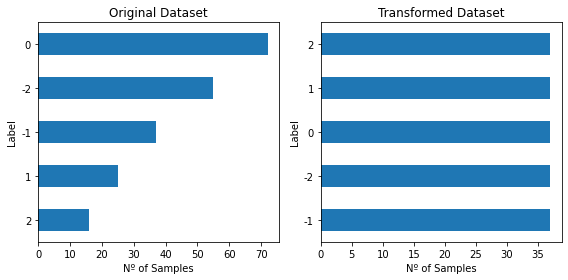

In [46]:
df_orig = pd.read_csv('dataset_sa.csv', encoding='ansi')
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1, title='Original Dataset')
ax = df_orig['label'].value_counts(sort=True, ascending=True).plot(kind='barh')
ax.set_xlabel('Nº of Samples')
ax.set_ylabel('Label')
plt.subplot(1, 2, 2, title='Transformed Dataset')
ax = y_over.value_counts(sort=True, ascending=True).plot(kind='barh')
ax.set_xlabel('Nº of Samples')
ax.set_ylabel('Label')
plt.tight_layout()

When trying to predict the sentiment score _label_, we have seen that some common Python libraries able to generate this type of scores can not be used as a prediction model for this task (their precision and recall values are too low, including the _bert_sentiment_ score). _label_ is evaluating the sentiment of the tweets taking into account more aspects, such as the topic. That's why I decided to compare some ML classifiers with PyCaret to have a quick overview, finding out that some of them are performing well for this concrete task.

The code cell below shows the precision and recall scores for the test set BERT (_bert_sentiment_), Gradient Boosting Classifier and XGBoost Classifier:

In [47]:
predictions = y_test_bert.round().astype('int64')
print("\nBERT ('bert_sentiment')\n")
print(classification_report(y_test, predictions))
print('_____________________________________________________')

predictions = gb_clf_Grid.predict(X_test)
print("\nGradient Boosting Classifier\n") 
print(classification_report(y_test, predictions))
print('________________________________________')

predictions = xgb_clf_Grid.predict(X_test)
print("\nXGBoost Classifier\n")
print(classification_report(y_test, predictions))


BERT ('bert_sentiment')

              precision    recall  f1-score   support

          -2       0.50      0.15      0.24        13
          -1       0.32      0.50      0.39        12
           0       0.14      0.60      0.23         5
           1       0.33      0.20      0.25         5
           2       0.00      0.00      0.00        12

    accuracy                           0.26        47
   macro avg       0.26      0.29      0.22        47
weighted avg       0.27      0.26      0.22        47

_____________________________________________________

Gradient Boosting Classifier

              precision    recall  f1-score   support

          -2       0.77      0.77      0.77        13
          -1       0.77      0.83      0.80        12
           0       0.75      0.60      0.67         5
           1       0.56      1.00      0.71         5
           2       1.00      0.67      0.80        12

    accuracy                           0.77        47
   macro avg       0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


As mentioned before, the Decision Tree model has been discarded due to its nature although with more data all of the proposed models should be evaluated again. About the three models above:
- BERT is clearly not working for this task (that's why I have removed this feature when training the classifiers). Precision: 0.26. Recall: 0.29.
- Gradient Boosting Classifier is performing well, achieving an accuracy of 0.77 although with different precisions and recalls for each class. Precision: 0.77. Recall: 0.77.
- **The best model would be XGBoost Classifier**. It's able to achieve an accuracy value of 0.85 and perform very well for all the classes. **Precision: 0.84**. **Recall: 0.86**.

As an extra task, it would be interesting to try with word-embeddings models like FastText (or try different configurations with BERT).

## References

- https://towardsdatascience.com/sentiment-analysis-concept-analysis-and-applications-6c94d6f58c17
- https://realpython.com/sentiment-analysis-python/
- https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4
- https://towardsdatascience.com/fasttext-sentiment-analysis-for-tweets-a-straightforward-guide-9a8c070449a2
- https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/
- https://medium.com/strands-tech-corner/unbalanced-datasets-what-to-do-144e0552d9cd#:~:text=In%20simple%20terms%2C%20an%20unbalanced,specific%20class%20than%20the%20others.&text=Besides%2C%20the%20problem%20is%20that,class%20or%20classify%20unseen%20observations).
- https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
- https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/
- https://scikit-learn.org/stable/index.html
- https://pycaret.readthedocs.io/en/latest/api/classification.html